In [29]:
import pandas as pd
import pyranges as pr
import upsetplot
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [74]:
def read_h5(h5, as_pyranges=True):
    """
    Read h5 representation of a transcriptome

    Parameters:
        h5 (str): .h5 file to read from
        as_pyranges (bool): Convert bed representations to PyRanges objects

    Returns:
        ic (pandas DataFrame): Table detailing intron chains
        tss (pyranges PyRanges / pandas DataFrame): Bed representation of tss regions
        tes (pyranges PyRanges / pandas DataFrame): Bed represenation of tes regions
        m (pandas DataFrame): Map of transcript id to tss / ic / tes
    """

    ic = pd.read_hdf(h5, key='ic')
    tss = pd.read_hdf(h5, key='tss')
    tes = pd.read_hdf(h5, key='tes')
    try:
        m = pd.read_hdf(h5, key='map')
    except:
        m = None

    if as_pyranges:
        tss = pr.PyRanges(tss)
        tes = pr.PyRanges(tes)

    return ic, tss, tes, m

In [81]:
def read_bed(bed):
    tes = pr.read_bed('test_tes.bed').df
    tes['gene_id'] = tes.Name.str.split('_', expand=True)[0] 
    tes.rename({'ThickStart': 'source'}, axis=1, inplace=True)
    return tes

In [82]:
h5 = 'human_cerberus.h5'
# ic, tss, tes, m_df = read_h5(h5, as_pyranges=False)
bed = 'test_tes.bed'
tes = read_bed(bed)

In [83]:
tes.head()

,Chromosome,Start,End,Name,Score,Strand,source,gene_id
0,chr1,169794989,169795129,ENSG00000000460_1,.,+,"v40,v29,lapa",ENSG00000000460
1,chr1,169795358,169795459,ENSG00000000460_2,.,+,"v40,v29,lapa",ENSG00000000460
2,chr1,169794679,169794780,ENSG00000000460_3,.,+,"v40,v29,lapa",ENSG00000000460
3,chr1,169795870,169795971,ENSG00000000460_4,.,+,"v40,v29",ENSG00000000460
4,chr1,169661956,169662057,ENSG00000000460_5,.,+,"v40,v29",ENSG00000000460


In [84]:
tes_upset = upsetplot.from_memberships(tes.source.str.split(','), data=tes)

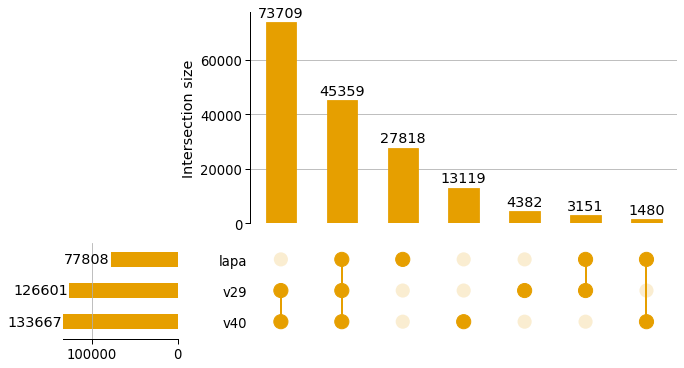

In [85]:
c_dict, _ = get_sector_colors()
c = c_dict['tes']
fig = plt.figure(figsize=(11,6))
sns.set_context('paper', font_scale=1.5)
upsetplot.plot(tes_upset, subset_size='auto',
                show_counts='%d', sort_by='cardinality', 
                facecolor=c, fig=fig, shading_color='white', element_size=None)

opref = 'figures/cerberus'
kind = 'tes'
fname = '{}_{}_source_upset.png'.format(opref, kind)
plt.savefig(fname, dpi=300, bbox_inches='tight')


In [86]:
tes['source'] = tes.source.str.split(',')
tes = tes.explode('source')
counts = tes[['Name', 'source']].groupby('source').count()
counts.rename({'Name': 'count'}, axis=1, inplace=True)

In [87]:
n_talon = counts.loc['lapa', 'count']
n_v29 = counts.loc['v29', 'count']
n_v40 = counts.loc['v40', 'count']

In [88]:
print('Detected {:.2f}% of v40 TESs'.format((n_talon/n_v40)*100))
print('Detected {:.2f}% of v29 TESs'.format((n_talon/n_v29)*100))

Detected 58.21% of v40 TESs
Detected 61.46% of v29 TESs


## How many ends does each gene have?

In [96]:
h5 = 'human_cerberus.h5'
# ic, tss, tes, m_df = read_h5(h5, as_pyranges=False)
bed = 'test_tes.bed'
tes = read_bed(bed)

In [97]:
len(tes.index)

169018

In [94]:
# number of affected genes
print(len(tes.loc[tes[['Chromosome', 'Start', 'End', 'Strand', 'gene_id']].duplicated(keep=False), 'gene_id'].unique()))
tes.loc[tes[['Chromosome', 'Start', 'End', 'Strand', 'gene_id']].duplicated(keep=False)]

0


,Chromosome,Start,End,Name,Score,Strand,source,gene_id


In [95]:
tes = tes.loc[tes.gene_id == 'ENSG00000081853']
tes

,Chromosome,Start,End,Name,Score,Strand,source,gene_id
44363,chr5,141338709,141338810,ENSG00000081853_1,.,+,"v40,v29,lapa",ENSG00000081853
44364,chr5,141338921,141339022,ENSG00000081853_2,.,+,"v29,lapa",ENSG00000081853


In [64]:
tes.loc[tes[['Chromosome', 'Start', 'End', 'Strand', 'gene_id']].duplicated(keep=False)]

,Chromosome,Start,End,Strand,Name,source,gene_id,tes
47300,chr5,141512928,141513029,+,ENSG00000081853_10,v29,ENSG00000081853,10
47301,chr5,141512928,141513029,+,ENSG00000081853_100,lapa,ENSG00000081853,100
47302,chr5,141512928,141513029,+,ENSG00000081853_101,lapa,ENSG00000081853,101
47303,chr5,141512928,141513029,+,ENSG00000081853_102,lapa,ENSG00000081853,102
47304,chr5,141512928,141513029,+,ENSG00000081853_103,lapa,ENSG00000081853,103
...,...,...,...,...,...,...,...,...
47779,chr5,141512928,141513029,+,ENSG00000081853_95,lapa,ENSG00000081853,95
47780,chr5,141512928,141513029,+,ENSG00000081853_96,lapa,ENSG00000081853,96
47781,chr5,141512928,141513029,+,ENSG00000081853_97,lapa,ENSG00000081853,97
47782,chr5,141512928,141513029,+,ENSG00000081853_98,lapa,ENSG00000081853,98


In [53]:
tes = tes[['gene_id', 'Name']]
tes = tes.groupby('gene_id').count().reset_index()
tes.rename({'Name': 'n_tes'}, axis=1, inplace=True)

In [56]:
# sns.displot(data=tes, x='n_tes')

In [57]:
tes.loc[tes.n_tes > 400]

,gene_id,n_tes
1548,ENSG00000081853,485
35534,ENSG00000240184,495
35772,ENSG00000240764,485
36458,ENSG00000242419,490
41015,ENSG00000253159,485
41139,ENSG00000253305,485
41292,ENSG00000253485,485
41335,ENSG00000253537,485
41508,ENSG00000253731,485
41608,ENSG00000253846,485


In [49]:
# where do the ends come from that are from this gene?
# ic, tss, tes, m_df = read_h5(h5, as_pyranges=False)
bed = 'test_tes.bed'
tes = read_bed(bed)

In [50]:
temp = tes.loc[tes.gene_id == 'ENSG00000240184']
temp = temp[['Name', 'source']]
temp.groupby('source').count()

,Name
source,
lapa,464
v29,24
v40,3
"v40,v29",3
"v40,v29,lapa",1
